In [2]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 265.5 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 265.5 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 265.5 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 265.5 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 265.5 kB/s e

LightGBM has been selected as it performed best in experiments
The final model will be an ensemble model between a classifier of whether players get any vote share and a regressor of their vote share multiplied together

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, StratifiedKFold
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')

In [234]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', None)

In [113]:
df_enrich = pd.read_csv('../data/enriched_nba_player_data.csv')
df_raw = pd.read_csv('../data/historic_nba_player_data.csv')
df_raw

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,Share
0,2003,Tracy McGrady,39.400,32.100,5.500,6.500,1.700,0.800,0.564,30.300,16.100,10.500,9.300,35.200,0.512,0.359
1,2003,Kobe Bryant,41.500,30.000,5.900,6.900,2.200,0.800,0.550,26.200,14.900,7.100,7.700,32.900,0.610,0.417
2,2003,Allen Iverson,42.500,27.600,5.500,4.200,2.700,0.200,0.500,21.200,9.200,3.500,4.800,32.900,0.585,0.070
3,2003,Shaquille O'Neal,37.800,27.500,3.100,11.100,0.600,2.400,0.602,29.500,13.200,6.500,5.500,30.200,0.610,0.106
4,2003,Paul Pierce,39.200,25.900,4.400,7.300,1.800,0.800,0.532,22.700,10.100,4.900,5.400,33.200,0.537,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11338,2025,Riley Minix,7.000,0.000,0.000,2.000,0.000,0.000,0.000,-1.700,0.000,-11.800,0.000,6.100,0.415,0.000
11339,2025,Jahlil Okafor,3.000,0.000,1.000,1.000,0.000,0.000,0.000,13.800,0.000,7.500,0.000,0.000,0.610,0.000
11340,2025,Zyon Pullin,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-11.700,0.000,-22.700,0.000,13.400,0.585,0.000
11341,2025,Isaiah Stevens,2.000,0.000,0.000,0.700,0.300,0.000,0.000,0.100,0.000,-11.800,0.000,14.800,0.451,0.000


In [114]:
train = df_enrich[df_enrich['Season'] < 2025].copy()
test = df_enrich[df_enrich['Season'] == 2025].copy()

In [115]:
train['has_votes'] = (train['Share'] > 0).astype('int')
train

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,VORP_W/L,Share,has_votes
0,2003,Tracy McGrady,1.753,3.907,1.977,0.989,2.029,0.548,1.094,3.680,3.819,3.534,5.219,3.400,0.512,4.542,0.359,1
1,2003,Kobe Bryant,1.989,3.547,2.209,1.160,3.128,0.548,0.823,2.770,3.455,2.480,4.230,2.923,0.610,4.474,0.417,1
2,2003,Allen Iverson,2.102,3.137,1.977,0.006,4.226,-0.554,-0.148,1.659,1.726,1.365,2.437,2.923,0.585,2.467,0.070,1
3,2003,Shaquille O'Neal,1.572,3.120,0.585,2.956,-0.388,3.486,1.832,3.502,2.940,2.295,2.870,2.364,0.610,3.048,0.106,1
4,2003,Paul Pierce,1.730,2.846,1.339,1.332,2.249,0.548,0.473,1.992,1.999,1.799,2.808,2.986,0.537,2.565,0.001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8804,2024,Jason Preston,-1.534,-1.290,-0.068,-0.702,-1.162,-0.899,-3.555,-0.683,-1.023,-0.508,-0.488,-1.041,0.378,-0.481,0.000,0
8805,2024,Ibou Badji,-1.509,-1.320,-0.961,-0.745,-1.732,0.976,0.793,-1.191,-0.950,-1.482,-0.630,-1.821,0.256,-0.541,0.000,0
8806,2024,Dariq Whitehead,-1.295,-1.320,-0.488,-0.874,-2.017,0.038,-4.419,-1.869,-1.023,-2.121,-0.488,-1.360,0.390,-0.481,0.000,0
8807,2024,Jack White,-0.793,-1.320,-1.118,-0.444,0.832,-0.431,-5.368,-2.674,-1.059,-2.852,-0.559,-1.094,0.329,-0.520,0.000,0


In [151]:
X_train = train[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]
X_test = test[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

y_regr = train['Share']
y_class = train['has_votes']
y_regr_test = test['Share']
y_class_test = (test['Share'] > 0).astype('int')

In [130]:
param_grid = {
    "num_leaves": [15, 30, 50],
    "max_depth": [10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [600, 700, 800],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.9, 0.95]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    lgb.LGBMClassifier(objective="binary", boosting_type='gbdt', random_state=42),
    param_grid,
    n_iter=30,
    scoring='recall',
    verbose=1,
    cv=cv,
    n_jobs=-1
)

search.fit(X_train, y_class)
best_model = search.best_estimator_
print('Best params:', search.best_params_)
print('Best recall score:', search.best_score_)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 297, number of negative: 8512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 8809, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033716 -> initscore=-3.355500
[LightGBM] [Info] Start training from score -3.355500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [131]:
pd.DataFrame(search.cv_results_)[["params", "mean_test_score"]].sort_values("mean_test_score", ascending=False).head(10)

,params,mean_test_score
9,"{'subsample': 1, 'num_leaves': 50, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.95}",0.717
22,"{'subsample': 0.9, 'num_leaves': 50, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.95}",0.714
20,"{'subsample': 0.9, 'num_leaves': 50, 'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}",0.707
11,"{'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}",0.707
27,"{'subsample': 1, 'num_leaves': 15, 'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.95}",0.704
3,"{'subsample': 1, 'num_leaves': 30, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.9}",0.704
24,"{'subsample': 1, 'num_leaves': 15, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9}",0.704
1,"{'subsample': 1, 'num_leaves': 30, 'n_estimators': 700, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.9}",0.704
18,"{'subsample': 0.8, 'num_leaves': 15, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.95}",0.700
23,"{'subsample': 0.9, 'num_leaves': 15, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}",0.700


In [132]:
lgb_class = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    num_leaves=50,
    max_depth=10,
    learning_rate=0.1,
    n_estimators=600,
    subsample=1,
    colsample_bytree=0.95
)

lgb_class.fit(X_train, y_class)    

[LightGBM] [Info] Number of positive: 297, number of negative: 8512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 8809, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033716 -> initscore=-3.355500
[LightGBM] [Info] Start training from score -3.355500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(colsample_bytree=0.95, max_depth=10, n_estimators=600,
               num_leaves=50, objective='binary', random_state=42, subsample=1)

In [150]:
yhat_class_train = lgb_class.predict(X_train)
yhat_proba_train = lgb_class.predict_proba(X_train)[:, 1]

print('Accuracy Score:', accuracy_score(y_class, yhat_class_train))
print('Precision Score:', precision_score(y_class, yhat_class_train))
print('Recall Score:', recall_score(y_class, yhat_class_train))
print('F1 Score:', f1_score(y_class, yhat_class_train))
print('ROC-AUC Score:',roc_auc_score(y_class, yhat_proba_train))

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1 Score: 1.0
ROC-AUC Score: 1.0


In [152]:
yhat_class_test = lgb_class.predict(X_test)
yhat_proba_test = lgb_class.predict_proba(X_test)[:, 1]

print('Accuracy Score:', accuracy_score(y_class_test, yhat_class_test))
print('Precision Score:', precision_score(y_class_test, yhat_class_test))
print('Recall Score:', recall_score(y_class_test, yhat_class_test))
print('F1 Score:', f1_score(y_class_test, yhat_class_test))
print('ROC-AUC Score:',roc_auc_score(y_class_test, yhat_proba_test))

Accuracy Score: 0.9847826086956522
Precision Score: 0.7272727272727273
Recall Score: 0.6666666666666666
F1 Score: 0.6956521739130435
ROC-AUC Score: 0.9947916666666667


In [162]:
param_grid = {
    "num_leaves": [30, 40, 50],
    "max_depth": [-1, 5, 10],
    "learning_rate": [0.01],
    "n_estimators": [400, 500, 600],
    "subsample": [0.7, 0.75, 0.8],
    "colsample_bytree": [0.7]
}

search_regr = RandomizedSearchCV(
    lgb.LGBMRegressor(objective="regression", random_state=42),
    param_grid,
    n_iter=30,
    scoring="r2",
    cv=4,
    n_jobs=-1
)

search_regr.fit(X_train, y_regr)
lgb_regr = search_regr.best_estimator_
print('Best params:', search_regr.best_params_)
print('Best r2:', search_regr.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 8809, number of used features: 14
[LightGBM] [Info] Start training from score 0.006492
Best params: {'subsample': 0.7, 'num_leaves': 40, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best r2: 0.7501343821222404


In [163]:
pd.DataFrame(search_regr.cv_results_)[["params", "mean_test_score"]].sort_values("mean_test_score", ascending=False).head(10)

,params,mean_test_score
4,"{'subsample': 0.7, 'num_leaves': 40, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
2,"{'subsample': 0.7, 'num_leaves': 40, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
23,"{'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
29,"{'subsample': 0.75, 'num_leaves': 30, 'n_estimators': 600, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
13,"{'subsample': 0.8, 'num_leaves': 30, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
15,"{'subsample': 0.7, 'num_leaves': 30, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
20,"{'subsample': 0.8, 'num_leaves': 30, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
16,"{'subsample': 0.8, 'num_leaves': 40, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.750
25,"{'subsample': 0.75, 'num_leaves': 40, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.749
24,"{'subsample': 0.7, 'num_leaves': 40, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7}",0.749


In [164]:
lgb_regr = lgb.LGBMRegressor(
    objective="regression",
    random_state=42,
    num_leaves=40,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7
)

lgb_regr.fit(X_train, y_regr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 8809, number of used features: 14
[LightGBM] [Info] Start training from score 0.006492


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, n_estimators=500,
              num_leaves=40, objective='regression', random_state=42,
              subsample=0.7)

In [165]:
yhat_regr_train = lgb_regr.predict(X_train)

print('MAE:', mean_absolute_error(yhat_regr_train, y_regr))
print('r2 Score:', r2_score(yhat_regr_train, y_regr))

MAE: 0.002684627690101107
r2 Score: 0.87505990575123


In [175]:
yhat_regr_test = lgb_regr.predict(X_test)

print('MAE:', mean_absolute_error(yhat_regr_test, y_regr_test))
print('r2 Score:', r2_score(yhat_regr_test, y_regr_test))

MAE: 0.0016921699769240528
r2 Score: 0.9690427692873095


In [178]:
df_test = test.copy()
yhat_test = np.clip(yhat_class_test * yhat_regr_test, a_min=0, a_max=None)
df_test.loc[X_test.index, 'yhat'] = yhat_test
# df_test.loc[X_test.index, 'yhat_class'] = yhat_class_test

In [187]:
print('MAE:', mean_absolute_error(yhat_test, y_regr_test))
print('r2 Score:', r2_score(yhat_test, y_regr_test))
print("Spearman Rank Correlation:", spearmanr(yhat_test, y_regr_test).correlation)

MAE: 0.0009185810989181439
r2 Score: 0.9774771736062028
Spearman Rank Correlation: 0.6953251676091113


In [224]:
df_test.sort_values(by=['Share', 'yhat', 'VORP_W/L'], ascending=False).head(15)

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,VORP_W/L,Share,yhat
8809,2025,Shai Gilgeous-Alexander,1.528,3.559,2.159,0.354,2.406,1.270,1.080,3.826,5.359,3.971,6.385,2.918,0.829,8.778,0.913,0.891
8811,2025,Nikola Jokić,1.859,3.061,4.239,3.691,2.667,0.311,1.487,4.126,5.244,4.555,7.083,1.952,0.610,7.018,0.787,0.763
8810,2025,Giannis Antetokounmpo,1.528,3.190,2.214,3.344,0.317,1.749,0.893,3.780,3.367,3.322,4.602,2.991,0.585,4.356,0.470,0.370
8814,2025,Jayson Tatum,1.819,2.612,1.940,1.957,0.839,0.071,0.221,1.748,2.601,1.926,3.206,2.262,0.744,3.992,0.311,0.174
8832,2025,Donovan Mitchell,1.157,2.162,1.393,0.137,1.361,-0.648,0.111,1.563,1.873,1.439,1.966,2.207,0.780,2.640,0.074,0.016
8827,2025,LeBron James,1.620,2.227,3.144,1.567,0.578,0.311,0.565,1.979,1.911,2.056,3.129,2.062,0.610,3.107,0.016,0.013
8813,2025,Anthony Edwards,1.806,2.740,1.119,0.657,1.100,0.311,0.424,1.378,2.180,1.634,3.051,2.299,0.598,2.961,0.012,0.010
8817,2025,Cade Cunningham,1.634,2.499,3.637,0.830,0.578,0.790,-0.045,1.494,1.222,1.504,2.353,2.627,0.537,2.000,0.012,0.000
8826,2025,Stephen Curry,1.263,2.243,1.940,0.094,0.839,-0.169,0.783,1.702,1.988,2.283,3.206,2.007,0.585,3.032,0.002,0.000
8871,2025,Evan Mobley,1.038,1.280,0.408,2.217,0.317,2.709,1.018,1.886,2.409,1.732,2.276,0.805,0.780,3.032,0.001,0.013


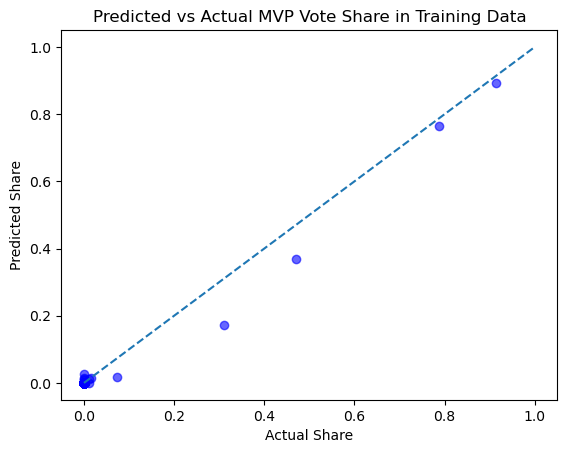

In [259]:
plt.scatter(y_regr_test, yhat_test, alpha=0.6, color='b')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Training Data")
plt.show()